# Install and Import Dependencies

In [ ]:
# The prophet library (formerly known as fbprophet) was developed by Facebook Core Data Science team


#!pip install prophet 

In [ ]:
#!pip install statsmodels

In [2]:
import pandas as pd 
import prophet
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller #Augmented Dickey-Fuller (ADF) Test, which is a statistical test designed to check for stationarity in a time series.
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
import numpy as np

import warnings 
warnings.simplefilter('ignore')

C:\Users\HP\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Read in Data and Process Dates

In [4]:
df = pd.read_csv('Profit.csv')
df.head()

,Time Date,Product,Store,Value
0,1012018,2667437,QLD_CW_ST0203,2926.000
1,2012018,2667437,QLD_CW_ST0203,2687.531
2,3012018,2667437,QLD_CW_ST0203,2793.000
3,4012018,2667437,QLD_CW_ST0203,2394.000
4,5012018,2667437,QLD_CW_ST0203,2660.000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Time Date  1080 non-null   int64  
 1   Product    1080 non-null   int64  
 2   Store      1080 non-null   object 
 3   Value      1080 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 33.9+ KB


[Learn lambda](https://youtu.be/MvWMpCK5ZHM?list=PLKdU0fuY4OFf7qj4eoBtvALAB_Ml2rN0V)

In [7]:
df['Year'] = df['Time Date'].apply(lambda x: str(x)[-4:])  #lambda arguments : expression

In [8]:
df.head()

,Time Date,Product,Store,Value,Year
0,1012018,2667437,QLD_CW_ST0203,2926.000,2018
1,2012018,2667437,QLD_CW_ST0203,2687.531,2018
2,3012018,2667437,QLD_CW_ST0203,2793.000,2018
3,4012018,2667437,QLD_CW_ST0203,2394.000,2018
4,5012018,2667437,QLD_CW_ST0203,2660.000,2018


In [9]:
df.tail()

,Time Date,Product,Store,Value,Year
1075,12122020,2667437,QLD_CW_ST0203,3167.594500,2020
1076,13122020,2667437,QLD_CW_ST0203,3167.594500,2020
1077,14122020,2667437,QLD_CW_ST0203,3383.354511,2020
1078,15122020,2667437,QLD_CW_ST0203,2714.591329,2020
1079,16122020,2667437,QLD_CW_ST0203,2585.035107,2020


In [10]:
df['Month'] = df['Time Date'].apply(lambda x: str(x)[-6:-4])

df['Day'] = df['Time Date'].apply(lambda x: str(x)[:-6])

In [11]:
df.head()

,Time Date,Product,Store,Value,Year,Month,Day
0,1012018,2667437,QLD_CW_ST0203,2926.000,2018,01,1
1,2012018,2667437,QLD_CW_ST0203,2687.531,2018,01,2
2,3012018,2667437,QLD_CW_ST0203,2793.000,2018,01,3
3,4012018,2667437,QLD_CW_ST0203,2394.000,2018,01,4
4,5012018,2667437,QLD_CW_ST0203,2660.000,2018,01,5


In [12]:
df['Formated Date'] = pd.DatetimeIndex(df['Year']+'-'+df['Month']+'-'+df['Day'])
df.head()

,Time Date,Product,Store,Value,Year,Month,Day,Formated Date
0,1012018,2667437,QLD_CW_ST0203,2926.000,2018,01,1,2018-01-01
1,2012018,2667437,QLD_CW_ST0203,2687.531,2018,01,2,2018-01-02
2,3012018,2667437,QLD_CW_ST0203,2793.000,2018,01,3,2018-01-03
3,4012018,2667437,QLD_CW_ST0203,2394.000,2018,01,4,2018-01-04
4,5012018,2667437,QLD_CW_ST0203,2660.000,2018,01,5,2018-01-05


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Time Date      1080 non-null   int64         
 1   Product        1080 non-null   int64         
 2   Store          1080 non-null   object        
 3   Value          1080 non-null   float64       
 4   Year           1080 non-null   object        
 5   Month          1080 non-null   object        
 6   Day            1080 non-null   object        
 7   Formated Date  1080 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 67.6+ KB


In [24]:
df.Store.value_counts()

Store
QLD_CW_ST0203    1080
Name: count, dtype: int64

In [26]:
df.shape

(1080, 8)

In [28]:
#df = df.loc[(df['Store']=='QLD_CW_ST0203') & (df['Product']==2667437)]

In [30]:
df.drop(['Time Date', 'Product', 'Store', 'Year', 'Month', 'Day'], axis=1, inplace=True)
df.columns = ['Value', 'Formated Date']

In [32]:
df.head()

,Value,Formated Date
0,2926.000,2018-01-01
1,2687.531,2018-01-02
2,2793.000,2018-01-03
3,2394.000,2018-01-04
4,2660.000,2018-01-05


In [34]:
df_fb = df.copy()
df_fb.head()

,Value,Formated Date
0,2926.000,2018-01-01
1,2687.531,2018-01-02
2,2793.000,2018-01-03
3,2394.000,2018-01-04
4,2660.000,2018-01-05


# Towards ARIMA Model

In [37]:
df.set_index('Formated Date', inplace=True)
df.head()

,Value
Formated Date,
2018-01-01,2926.000
2018-01-02,2687.531
2018-01-03,2793.000
2018-01-04,2394.000
2018-01-05,2660.000


# Plot the time series

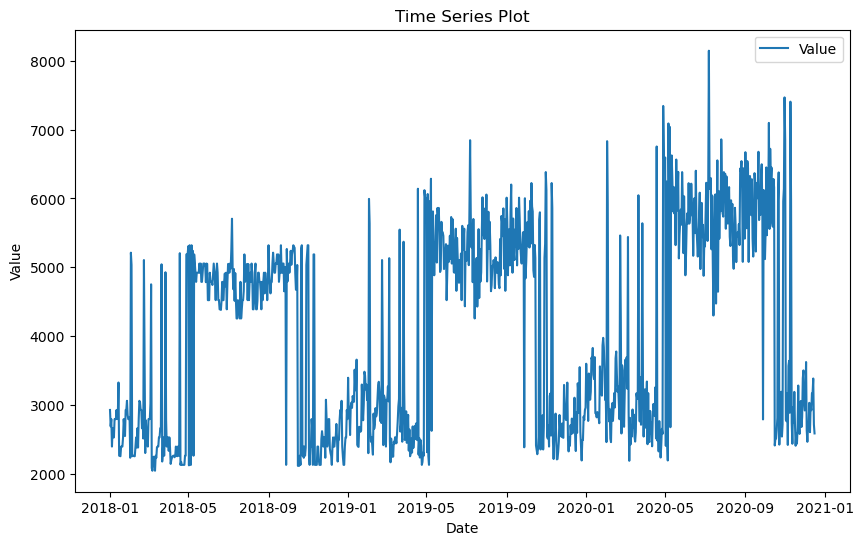

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Value'], label='Value')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Perform ADF Test

A time series is `stationary` if its statistical properties (mean, variance, autocorrelation) do not change over time. ARIMA models assume stationarity. If your series is not stationary, the model may produce `misleading results`.

#### Why Use the ADF Test?
The ADF Test helps you determine whether a time series is stationary by testing the null hypothesis: <br>

`Null Hypothesis (H₀):` The series has a unit root → it is non-stationary <br>
`Alternative Hypothesis (H₁):` The time series is stationary. <br>
`p-value:` If the p-value is less than 0.05 (p ≤ 0.05), you reject the null hypothesis, meaning the series is `stationary`.

# Now that differencing has been applied

In ARIMA models, differencing is a technique used to transform a non-stationary time series into a stationary one by calculating the difference between consecutive data points. 

In [41]:
result = adfuller(df['Value'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -2.2124789527935995
p-value: 0.20174753235777337


In [43]:
if result[1] > 0.05:
    print("The series is not stationary. Differencing will be applied.")
    df['Value_Diff'] = df['Value'].diff().dropna()

else:
    print("The series is stationary. Proceeding without differencing.")

The series is not stationary. Differencing will be applied.


# Stationarity in Forecasting

1. Many time series models (ARIMA, SARIMA) assume stationarity because their mathematical principles are based on constant mean and variance. <br>
2. Non-stationary series can lead to poor predictions unless stationarity is achieved through transformations.

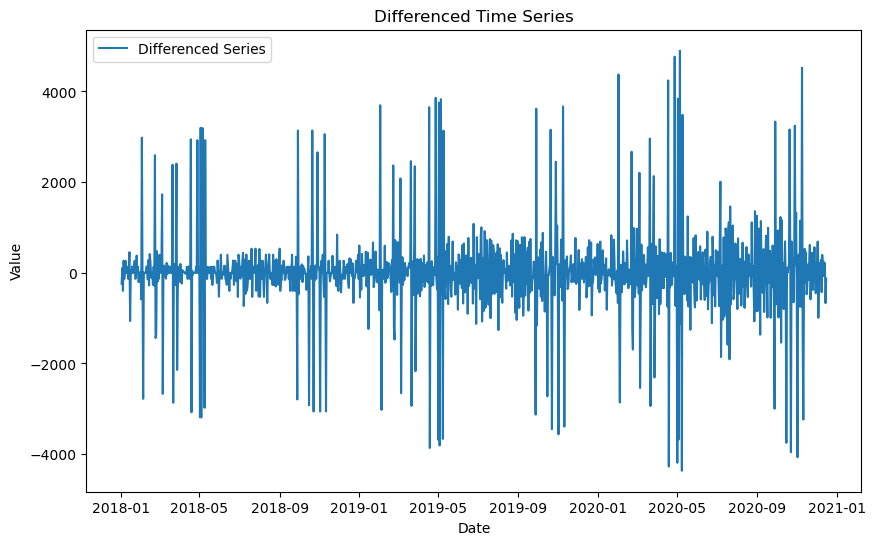

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(df['Value_Diff'], label='Differenced Series')
plt.title('Differenced Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

After `differencing`, the series is transformed to `remove` trends or seasonality. This makes the series stationary (constant mean and variance). The resulting plot often appears like a random, mean-reverting process with no discernible trends or patterns.

In [47]:
df.head()

,Value,Value_Diff
Formated Date,,
2018-01-01,2926.000,NaN
2018-01-02,2687.531,-238.469
2018-01-03,2793.000,105.469
2018-01-04,2394.000,-399.000
2018-01-05,2660.000,266.000


In [49]:
df = df.drop(df.index[0])  # Drop the first row

# Perform the ADF test again on the differenced series

In [51]:
result_diff = adfuller(df['Value_Diff'])
print("ADF Statistic (Differenced):", result_diff[0])
print("p-value (Differenced):", result_diff[1])

if result_diff[1] > 0.05:
    print("The differenced series is still not stationary.")
else:
    print("The differenced series is stationary. Ready for ARIMA modeling.")


ADF Statistic (Differenced): -9.498547019849957
p-value (Differenced): 3.4952395496449434e-16
The differenced series is stationary. Ready for ARIMA modeling.


In [53]:
df.head()

,Value,Value_Diff
Formated Date,,
2018-01-02,2687.531,-238.469
2018-01-03,2793.000,105.469
2018-01-04,2394.000,-399.000
2018-01-05,2660.000,266.000
2018-01-06,2527.000,-133.000


In [55]:
df = df.drop(['Value_Diff'], axis=1)
df.head()

,Value
Formated Date,
2018-01-02,2687.531
2018-01-03,2793.000
2018-01-04,2394.000
2018-01-05,2660.000
2018-01-06,2527.000


# Define ARIMA parameters (p, d, q)

In [58]:
df = df.asfreq('D')  # Assign a daily frequency
print(df.index.freq)  # Should show 'D' for daily data, also alailable, H, W, Y

<Day>


In [60]:
# Specifies the ARIMA model configuration.
p, d, q = 2, 1, 2 # p -> AutoRegressive Order, d-> Differencing Order, q-> Moving Average Order

# Fit the ARIMA model
arima_model = ARIMA(df['Value'], order=(p, d, q))  # Use the original 'Value' column
arima_fitted = arima_model.fit()

`Step 1:` First-order differencing (d=1) is applied to the series to remove trends and make it stationary. <br>
`Step 2:` The AR (AutoRegressive) part (p=2) fits a model using the last 2 lagged values of the differenced series. <br>
`Step 3:` The MA (Moving Average) part (q=2) incorporates the last 2 error terms from previous predictions.

The past lags (p) and error terms (q) will continue to `influence future values` in the same way as they did during the training period.

In [64]:
# Print the model summary
print(arima_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                 1080
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -8796.609
Date:                Sat, 21 Feb 2026   AIC                          17603.218
Time:                        10:33:47   BIC                          17628.137
Sample:                    01-02-2018   HQIC                         17612.654
                         - 12-16-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4786      0.145     -3.298      0.001      -0.763      -0.194
ar.L2          0.1836      0.056      3.290      0.001       0.074       0.293
ma.L1         -0.0926      0.145     -0.638      0.5

# Interpreting results

`Log Likelihood:` -8796.609 <br>
Higher (less negative) values indicate a better fit. <br>
`AIC (Akaike Information Criterion):` 17603.218 <br> 
AIC (Akaike Information Criterion) is a metric used to compare models — `lower` is better. It penalize complexity and reward goodness-of-fit <br>
`BIC (Bayesian Information Criterion):` 17628.137 <br>
Similar to AIC but penalizes complexity more strongly. <br>
`HQIC (Hannan-Quinn Information Criterion):` 17612.654 <br>
Another model selection criterion, balancing fit and complexity. <br>

## Tune ARIMA to automatically select the best (p, d, q) parameters

To automatically tune the best ARIMA model parameters, you can use the `pmdarima` library, which provides the `auto_arima()` function. This function tests multiple combinations of `(p, d, q)` values and selects the best model based on a criterion like AIC (Akaike Information Criterion). First, install the library using `pip install pmdarima`. Then, apply `auto_arima()` to your time series data (e.g., `df['Value']`). Set `seasonal=False` for a regular ARIMA model (or `True` if seasonality is present), and `trace=True` to view the combinations being tested. The function will return the model with the lowest AIC, indicating the best balance of fit and complexity. You can then use the fitted model to forecast future values with `.predict()`. This approach saves time and improves model accuracy by automating the tuning process.


# Forecast future values

In [66]:
forecast_steps = 20  # Number of steps to forecast
forecast = arima_fitted.forecast(steps=forecast_steps)
print("ARIMA Forecast:\n",forecast)

ARIMA Forecast:
 2020-12-17    2844.786766
2020-12-18    2885.430708
2020-12-19    2913.668865
2020-12-20    2907.615805
2020-12-21    2915.697556
2020-12-22    2910.718085
2020-12-23    2914.585209
2020-12-24    2911.820068
2020-12-25    2913.853545
2020-12-26    2912.372588
2020-12-27    2913.454760
2020-12-28    2912.664899
2020-12-29    2913.241635
2020-12-30    2912.820575
2020-12-31    2913.127995
2021-01-01    2912.903549
2021-01-02    2913.067417
2021-01-03    2912.947777
2021-01-04    2913.035126
2021-01-05    2912.971352
Freq: D, Name: predicted_mean, dtype: float64


# Prophet Model

[Read - Facebook GitHub](https://facebook.github.io/prophet/docs/quick_start.html)

In [70]:
df_fb.head()

,Value,Formated Date
0,2926.000,2018-01-01
1,2687.531,2018-01-02
2,2793.000,2018-01-03
3,2394.000,2018-01-04
4,2660.000,2018-01-05


In [72]:
df_fb.tail()

,Value,Formated Date
1075,3167.594500,2020-12-12
1076,3167.594500,2020-12-13
1077,3383.354511,2020-12-14
1078,2714.591329,2020-12-15
1079,2585.035107,2020-12-16


In [74]:
df_fb.columns = ['y', 'ds']
df_fb.head()

,y,ds
0,2926.000,2018-01-01
1,2687.531,2018-01-02
2,2793.000,2018-01-03
3,2394.000,2018-01-04
4,2660.000,2018-01-05


In [76]:
m = Prophet(interval_width=0.95, daily_seasonality=True)
model = m.fit(df_fb)

10:34:06 - cmdstanpy - INFO - Chain [1] start processing
10:34:07 - cmdstanpy - INFO - Chain [1] done processing


In Prophet, interval_width=0.95 sets the forecast's confidence interval to 95%, meaning the model expects the true future values to fall within this range 95% of the time. A higher interval width gives wider uncertainty bands, reflecting greater confidence but less precision.

If Prophet forecasts a value of 200 for a date, and the 95% interval is: <br>
Lower bound: 180 <br>
Upper bound: 220 <br>
Then you're 95% confident the true value will be between 180 and 220.

# 3. Forecast Away

In [80]:
future = m.make_future_dataframe(periods=1000,freq='D')
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,3042.707031,855.423462,4040.444038,3042.707031,3042.707031,-636.756103,-636.756103,-636.756103,472.567854,...,16.615615,16.615615,16.615615,-1125.939571,-1125.939571,-1125.939571,0.0,0.0,0.0,2405.950928
1,2018-01-02,3043.438906,824.109626,4044.145955,3043.438906,3043.438906,-646.926343,-646.926343,-646.926343,472.567854,...,-11.291457,-11.291457,-11.291457,-1108.202740,-1108.202740,-1108.202740,0.0,0.0,0.0,2396.512563
2,2018-01-03,3044.170781,886.524234,3904.925429,3044.170781,3044.170781,-621.142084,-621.142084,-621.142084,472.567854,...,-4.423814,-4.423814,-4.423814,-1089.286123,-1089.286123,-1089.286123,0.0,0.0,0.0,2423.028697
3,2018-01-04,3044.902656,875.719302,4166.019616,3044.902656,3044.902656,-574.199279,-574.199279,-574.199279,472.567854,...,22.497906,22.497906,22.497906,-1069.265039,-1069.265039,-1069.265039,0.0,0.0,0.0,2470.703376
4,2018-01-05,3045.634530,765.703433,4004.159326,3045.634530,3045.634530,-610.265676,-610.265676,-610.265676,472.567854,...,-34.566045,-34.566045,-34.566045,-1048.267484,-1048.267484,-1048.267484,0.0,0.0,0.0,2435.368855


In [82]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2075,2023-09-08,5215.641293,5358.876618,8530.629710,5110.234178,5327.605041,1689.380015,1689.380015,1689.380015,472.567854,...,-34.566045,-34.566045,-34.566045,1251.378206,1251.378206,1251.378206,0.0,0.0,0.0,6905.021308
2076,2023-09-09,5216.727669,5288.397218,8518.807542,5111.188029,5328.906076,1712.526858,1712.526858,1712.526858,472.567854,...,-14.019317,-14.019317,-14.019317,1253.978321,1253.978321,1253.978321,0.0,0.0,0.0,6929.254528
2077,2023-09-10,5217.814046,5424.564398,8534.542466,5112.141880,5330.207111,1755.950474,1755.950474,1755.950474,472.567854,...,25.187112,25.187112,25.187112,1258.195508,1258.195508,1258.195508,0.0,0.0,0.0,6973.764520
2078,2023-09-11,5218.900423,5341.292923,8631.767158,5113.095731,5331.508146,1753.334430,1753.334430,1753.334430,472.567854,...,16.615615,16.615615,16.615615,1264.150961,1264.150961,1264.150961,0.0,0.0,0.0,6972.234853
2079,2023-09-12,5219.986800,5377.066551,8514.221826,5114.049582,5332.809181,1733.165284,1733.165284,1733.165284,472.567854,...,-11.291457,-11.291457,-11.291457,1271.888887,1271.888887,1271.888887,0.0,0.0,0.0,6953.152084


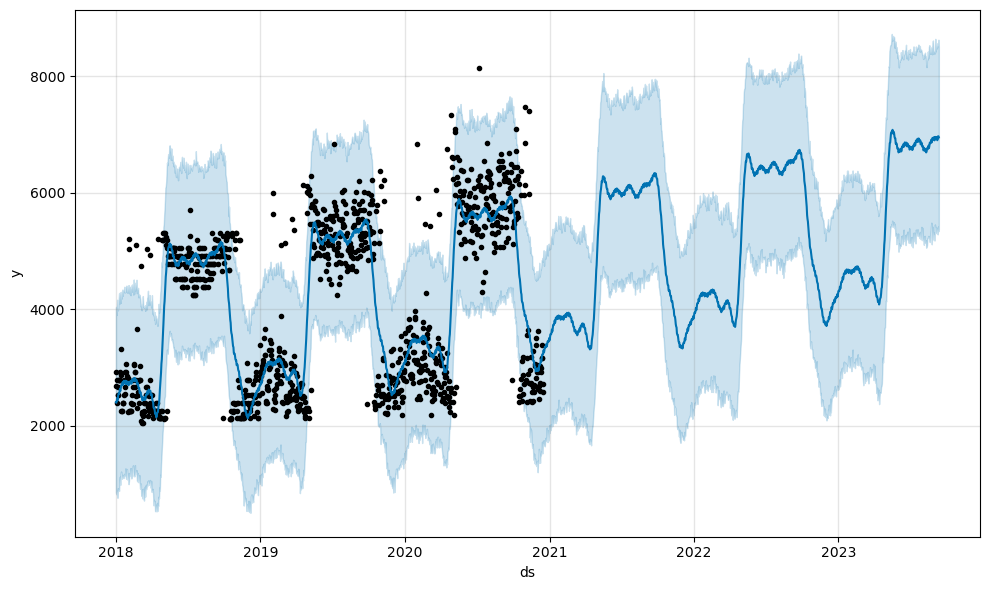

In [84]:
plot1 = m.plot(forecast)

In [88]:
specific_date = forecast[forecast['ds'] == '2023-01-01'] #yhat
specific_date

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1825,2023-01-01,4944.047069,2680.872046,5875.202805,4873.62293,5020.036238,-632.430847,-632.430847,-632.430847,472.567854,...,25.187112,25.187112,25.187112,-1130.185813,-1130.185813,-1130.185813,0.0,0.0,0.0,4311.616222
